In [48]:
pip install numpy scipy yfinance pandas matplotlib


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [49]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from typing import Tuple, Dict
import pandas as pd
import yfinance as yf
print("NumPy:", np.__version__)

NumPy: 2.2.5


## Étape 1 – Formule de Black–Scholes (Cas général avec dividendes)

Nous considérons le modèle de Black–Scholes–Merton pour des options 
avec un taux de dividende continu \( q \).

- S₀ : prix spot  
- K : prix d’exercice  
- r : taux d’intérêt sans risque  
- q : taux de dividende  
- σ : volatilité  
- T : maturité  

Les quantités clés sont :

$$
d_{1} = \frac{\ln(S_0/K) + (r - q + \sigma^{2}/2)T}{\sigma \sqrt{T}}
$$

$$
d_{2} = d_{1} - \sigma \sqrt{T}
$$

### Prix du Call
$$
C = S_0 e^{-qT} N(d_1) - K e^{-rT} N(d_2)
$$

### Prix du Put
$$
P = K e^{-rT} N(-d_2) - S_0 e^{-qT} N(-d_1)
$$

où  N(.) désigne la fonction de répartition (CDF) de la loi normale standard.


In [53]:
from math import log, sqrt, exp
from scipy.stats import norm


MODÈLE BLACK-SCHOLES

Paramètres:
  Prix spot (S):        100
  Strike (K):           105
  Maturité (T):         1 an(s)
  Taux sans risque (r): 5.00%
  Volatilité (σ):       20.00%
  Dividende (q):        2.00%

                Prix des options:                 
  Call: 6.9869
  Put:  8.8461

                  Grecques Call:                  
  Delta   : 0.492465
  Gamma   : 0.019552
  Vega    : 0.391036
  Theta   : -0.019201
  Rho     : 0.422596

                  Grecques Put:                   
  Delta   : -0.487734
  Gamma   : 0.019552
  Vega    : 0.391036
  Theta   : -0.005493
  Rho     : -0.576195

Vérification parité call-put: 0.0000000000 (doit être ≈ 0)

Volatilité implicite (à partir du prix théorique): 20.00%


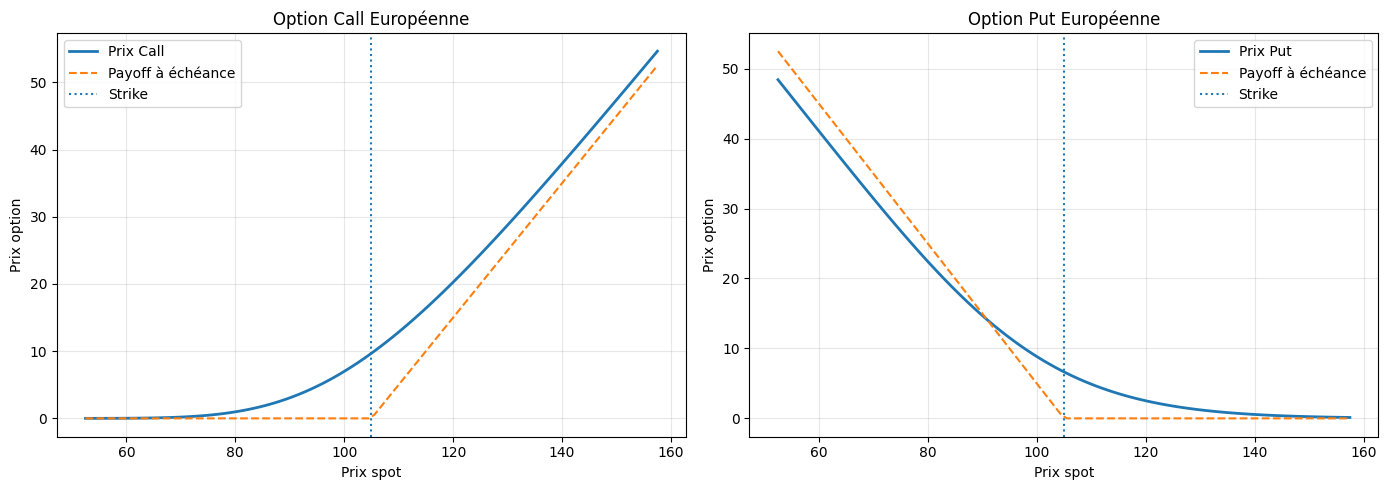

In [54]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from typing import Dict, Tuple


class BlackScholesModel:
    def __init__(self, S, K, T, r, sigma, q=0):
        """
        Modèle Black-Scholes-Merton pour options européennes.
        
        S : prix spot
        K : prix d'exercice (strike)
        T : maturité (années)
        r : taux sans risque (annuel)
        sigma : volatilité (annuelle)
        q : taux de dividende continu (annuel)
        """
        self.S = S
        self.K = K
        self.T = T
        self.r = r
        self.sigma = sigma
        self.q = q

    # ------------------ d1, d2 ------------------
    def _d1(self) -> float:
        return (np.log(self.S / self.K)
                + (self.r - self.q + 0.5 * self.sigma**2) * self.T) / (self.sigma * np.sqrt(self.T))

    def _d2(self) -> float:
        return self._d1() - self.sigma * np.sqrt(self.T)

    # ------------------ Prix call / put ------------------
    def call_price(self) -> float:
        d1 = self._d1()
        d2 = self._d2()
        return (self.S * np.exp(-self.q * self.T) * norm.cdf(d1)
                - self.K * np.exp(-self.r * self.T) * norm.cdf(d2))

    def put_price(self) -> float:
        d1 = self._d1()
        d2 = self._d2()
        return (self.K * np.exp(-self.r * self.T) * norm.cdf(-d2)
                - self.S * np.exp(-self.q * self.T) * norm.cdf(-d1))

    # ------------------ Grecques ------------------
    def greeks(self, option_type: str = "call") -> Dict[str, float]:
        d1 = self._d1()
        d2 = self._d2()
        sqrt_T = np.sqrt(self.T)

        # Delta
        if option_type == "call":
            delta = np.exp(-self.q * self.T) * norm.cdf(d1)
        else:
            delta = -np.exp(-self.q * self.T) * norm.cdf(-d1)

        # Gamma
        gamma = (np.exp(-self.q * self.T) * norm.pdf(d1)
                 / (self.S * self.sigma * sqrt_T))

        # Vega (par 1% de volatilité)
        vega = self.S * np.exp(-self.q * self.T) * norm.pdf(d1) * sqrt_T / 100

        # Theta (par jour)
        term1 = -self.S * norm.pdf(d1) * self.sigma * np.exp(-self.q * self.T) / (2 * sqrt_T)
        if option_type == "call":
            term2 = self.r * self.K * np.exp(-self.r * self.T) * norm.cdf(d2)
            term3 = -self.q * self.S * np.exp(-self.q * self.T) * norm.cdf(d1)
            theta = (term1 - term2 + term3) / 365
        else:
            term2 = self.r * self.K * np.exp(-self.r * self.T) * norm.cdf(-d2)
            term3 = self.q * self.S * np.exp(-self.q * self.T) * norm.cdf(-d1)
            theta = (term1 + term2 - term3) / 365

        # Rho (par 1% de taux)
        if option_type == "call":
            rho = self.K * self.T * np.exp(-self.r * self.T) * norm.cdf(d2) / 100
        else:
            rho = -self.K * self.T * np.exp(-self.r * self.T) * norm.cdf(-d2) / 100

        return {
            "delta": delta,
            "gamma": gamma,
            "vega": vega,
            "theta": theta,
            "rho": rho,
        }

    # ------------------ Volatilité implicite ------------------
    def implied_volatility(
        self,
        market_price: float,
        option_type: str = "call",
        tol: float = 1e-6,
        max_iter: int = 100,
    ) -> float:
        sigma = self.sigma if self.sigma > 0 else 0.2  # point de départ

        for _ in range(max_iter):
            old_sigma = self.sigma
            self.sigma = sigma

            price = self.call_price() if option_type == "call" else self.put_price()
            vega = self.greeks(option_type)["vega"] * 100  # car /100 dans greeks

            self.sigma = old_sigma

            diff = market_price - price
            if abs(diff) < tol:
                return sigma

            if vega == 0:
                break

            sigma = sigma + diff / vega
            sigma = max(sigma, 0.01)

        return sigma

    # ------------------ Graphique payoff ------------------
    def plot_payoff(self, spot_range: Tuple[float, float] = None):
        if spot_range is None:
            spot_range = (self.K * 0.5, self.K * 1.5)

        spots = np.linspace(spot_range[0], spot_range[1], 100)
        call_prices = []
        put_prices = []

        for spot in spots:
            bs = BlackScholesModel(spot, self.K, self.T, self.r, self.sigma, self.q)
            call_prices.append(bs.call_price())
            put_prices.append(bs.put_price())

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

        # Call
        ax1.plot(spots, call_prices, linewidth=2, label="Prix Call")
        ax1.plot(spots, np.maximum(spots - self.K, 0), "--", label="Payoff à échéance")
        ax1.axvline(self.K, linestyle=":", label="Strike")
        ax1.set_xlabel("Prix spot")
        ax1.set_ylabel("Prix option")
        ax1.set_title("Option Call Européenne")
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Put
        ax2.plot(spots, put_prices, linewidth=2, label="Prix Put")
        ax2.plot(spots, np.maximum(self.K - spots, 0), "--", label="Payoff à échéance")
        ax2.axvline(self.K, linestyle=":", label="Strike")
        ax2.set_xlabel("Prix spot")
        ax2.set_ylabel("Prix option")
        ax2.set_title("Option Put Européenne")
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()


# ================== Exemple d'utilisation ==================
def exemple_utilisation():
    # Paramètres
    S = 100
    K = 105
    T = 1
    r = 0.05
    sigma = 0.2
    q = 0.02

    bs = BlackScholesModel(S, K, T, r, sigma, q)

    call = bs.call_price()
    put = bs.put_price()

    print("=" * 50)
    print("MODÈLE BLACK-SCHOLES")
    print("=" * 50)
    print("\nParamètres:")
    print(f"  Prix spot (S):        {S}")
    print(f"  Strike (K):           {K}")
    print(f"  Maturité (T):         {T} an(s)")
    print(f"  Taux sans risque (r): {r*100:.2f}%")
    print(f"  Volatilité (σ):       {sigma*100:.2f}%")
    print(f"  Dividende (q):        {q*100:.2f}%")

    print(f"\n{'Prix des options:':^50}")
    print(f"  Call: {call:.4f}")
    print(f"  Put:  {put:.4f}")

    # Grecques
    call_greeks = bs.greeks("call")
    put_greeks = bs.greeks("put")

    print(f"\n{'Grecques Call:':^50}")
    for greek, value in call_greeks.items():
        print(f"  {greek.capitalize():8s}: {value:.6f}")

    print(f"\n{'Grecques Put:':^50}")
    for greek, value in put_greeks.items():
        print(f"  {greek.capitalize():8s}: {value:.6f}")

    # Parité call-put : C - P = S e^{-qT} - K e^{-rT}
    parity = call - put - (S * np.exp(-q * T) - K * np.exp(-r * T))
    print(f"\nVérification parité call-put: {abs(parity):.10f} (doit être ≈ 0)")

    # Volatilité implicite
    market_call_price = call  # on prend le prix théorique comme "marché"
    iv = bs.implied_volatility(market_call_price, "call")
    print(f"\nVolatilité implicite (à partir du prix théorique): {iv*100:.2f}%")

    # Graphiques
    bs.plot_payoff()


# À lancer dans ton notebook :
exemple_utilisation()


## 1. Prix des options

- **Call : 6.9869**  
- **Put : 8.8461**

Ces valeurs correspondent aux prix théoriques issus de la formule de Black–Scholes.  
Le Put est ici plus cher que le Call car **le strike (105) est supérieur au prix spot (100)** : le Put a donc une probabilité plus élevée d’être dans la monnaie à l’échéance.


## 2. Grecques

Les grecques mesurent la sensibilité du prix de l’option aux paramètres du marché.

### Call
- **Delta ≈ 0.49** → le Call réagit comme 0.49 actions.
- **Gamma ≈ 0.019** → convexité positive, le Delta augmente quand le prix bouge.
- **Vega ≈ 0.39** → forte sensibilité à la volatilité.
- **Theta < 0** → perte de valeur temps.
- **Rho > 0** → une hausse des taux augmente le prix du Call.

### Put
- **Delta ≈ -0.48**
- **Theta < 0**
- **Rho < 0**


### 3. Parité call–put

La relation théorique s’écrit :

$$
C - P = S_0 e^{-qT} - K e^{-rT}
$$

avec :

- \(C\) : prix du call européen  
- \(P\) : prix du put européen  
- \(S_0\) : prix spot de l’actif sous-jacent  
- \(K\) : prix d’exercice  
- \(r\) : taux sans risque  
- \(q\) : taux de dividende continu  
- \(T\) : maturité (en années)


## 4. Volatilité implicite

En utilisant le prix théorique comme “prix de marché”, la procédure d’inversion retrouve une volatilité implicite de :

**20.00%**

Ce résultat est cohérent puisque la volatilité utilisée dans le modèle est précisément 20%.


## 5. Graphiques Payoff & Prix

Les graphiques montrent :

### 1. Le prix du Call reste au-dessus de son payoff avant le strike  
Cela reflète la **valeur temps** : même si le payoff futur est nul lorsque \( S < K \), le Call conserve une valeur positive liée à la probabilité que le sous-jacent dépasse le strike avant l’échéance.

### 2. Le prix du Put présente la même logique  
La volatilité et le temps jusqu’à maturité ajoutent une valeur additionnelle.

### 3. La convexité du prix (Gamma positif)  
Les courbes bleues sont convexes, ce qui reflète une propriété fondamentale des options européennes.


## 6. Résumé

Cette implémentation du modèle de Black–Scholes calcule :

- les prix du Call et du Put,
- les grecques principales,
- la vérification de la parité call-put,
- la volatilité implicite via inversion numérique,
- les graphiques de payoff et de prix.

Les résultats obtenus sont cohérents avec la théorie :
- Call ≈ 6.99, Put ≈ 8.85,
- Delta ≈ ±0.49, Gamma ≈ 0.019, Vega ≈ 0.39,
- la parité call-put est vérifiée,
- la volatilité implicite retrouvée = 20%,
- les graphiques illustrent la convexité et la valeur temps.

Le modèle est robuste et constitue une base solide pour des extensions futures (Monte-Carlo, hedging, volatilité implicite de marché, backtests).


## 7. Limites du modèle (pour l'ésprit critique)

Warren Buffett et Charlie Munger qualifient Black-Scholes de modèle « insensé » et de « système mécanique » ignorant des variables essentielles, ce qui conduit souvent à des résultats absurdes sur de longues périodes. Selon eux, il s’agit d’un « know-nothing value system », un outil conçu pour des utilisateurs qui ne comprennent pas réellement le marché, ce qui crée des inefficiences exploitables uniquement par des investisseurs très patients et informés. Buffett insiste sur le fait que Black-Scholes donne une illusion de précision alors que les véritables opportunités sur le marché des options sont rares ; s’appuyer sur ce modèle sans comprendre la dynamique réelle du marché peut mener à des décisions dangereuses et à des pertes rapides.